# **Automatic Inflection**
**Inflection** is a key process in many languages. For example, English inflects nouns for singular/plurals (*dog*, *dogs*; *man*, *men*), as well as verbs for number (*I/you/we/they run*, *he/she/it runs*).

In this project, we will create a program to automatically inflect words. Automatic inflection is useful for building smarter spellcheckers, speech recognition, and other language technologies. 

### How do we do it?

We will use a technique called **finite-state machines**, which model processes as a series of transitions. Finite-state machines are efficient, easy to create, and don't require large datasets. We will use the [PyFoma](https://github.com/mhulden/pyfoma) library for creating FSMs.
***

## **Finite-State Machines**
Finite-state machines consist of a series of states with transitions between them. We can define FSTs using [regexes](<./skills/9. Regex.ipynb>).

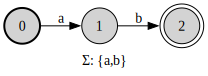

In [58]:
import pyfoma

fst1 = pyfoma.FST.re("ab")
fst1.view()

In the above FSM, there are three states (0, 1, 2) with two transitions (a, b). This FST will *accept* the string "ab" and nothing else.

In [59]:
print(list(fst1.generate("ab")))
print(list(fst1.generate("a")))
print(list(fst1.generate("b")))

['ab']
[]
[]


### Looping FSMs

If we add loops to the FSM, we can accept a repeated sequence any number of times. To do this, we can use the *star operator* that allows a symbol any number of times, as in `a*`. 

The following FST will accept a string with many `a`s repeated, followed by one `b`. 

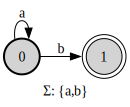

In [26]:
fst2 = pyfoma.FST.re("a*b")
fst2.view()

In [29]:
print(list(fst2.generate("ab")))
print(list(fst2.generate("aab")))
print(list(fst2.generate("aaab")))
print(list(fst2.generate("cb")))

['ab']
['aab']
['aaab']
[]


#### **Exercise 1**
Write an FSM that accepts only a string with one `c`, followed by any number of `a`s, followed by one `t`.

<details>
  <summary>Show answer</summary>
      <pre style="background-color: honeydew; padding: 10px; border-radius: 5px;"><code style="background: none;">fst3 = pyfoma.FST.re("ca*t")
fst3.view()</code></pre></details>

ct:	False, should be True
cat:	False, should be True
caat:	False, should be True
caaat:	False, should be True
caaaaaaaaaaaaaaaaaaat:	False, should be True
cbt:	False, should be False
cabt:	False, should be False


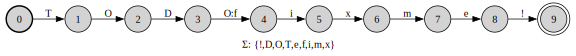

In [48]:
fst3 = pyfoma.FST.re("TODO: fix me!")

# Tests, don't edit these
print(f"ct:\t{list(fst3.generate('ct')) != []}, should be True")
print(f"cat:\t{list(fst3.generate('cat')) != []}, should be True")
print(f"caat:\t{list(fst3.generate('caat')) != []}, should be True")
print(f"caaat:\t{list(fst3.generate('caaat')) != []}, should be True")
print(f"caaaaaaaaaaaaaaaaaaat:\t{list(fst3.generate('caaaaaaaaaaaaaaaaaaat')) != []}, should be True")
print(f"cbt:\t{list(fst3.generate('cbt')) != []}, should be False")
print(f"cabt:\t{list(fst3.generate('cabt')) != []}, should be False")


fst3.view()

### Or Statements
We can use the bar `|` to specify an FST that accepts one symbol *or* another. For instance, the following will accept any number of `a`s or `b`s. 

['ab']
['aab']
['aabb']
['abbba']
[]


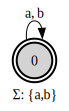

In [52]:
fst4 = pyfoma.FST.re("(a|b)*")

print(list(fst4.generate("ab")))
print(list(fst4.generate("aab")))
print(list(fst4.generate("aabb")))
print(list(fst4.generate("abbba")))
print(list(fst4.generate("cabbba")))

fst4.view()

### Finite-state transducers
FSMs can be used as **finite-state** ***transducers***, which take in one string and output another string. We can specify outputs using the colon `:`.

The following FST will accept any number of `a`s and output a `b` for every `a`.

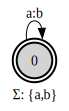

In [43]:
fst5 = pyfoma.FST.re("(a:b)*")
fst5.view()

Let's try inputting strings and see what is outputted.

In [44]:
print(list(fst5.generate("a")))
print(list(fst5.generate("aa")))
print(list(fst5.generate("aaa")))
print(list(fst5.generate("aaaa")))

['b']
['bb']
['bbb']
['bbbb']


We can create complicated FSTs by combining several states. The following FST will accept the word `dog` and output `dogs`.

['dogs']
[]


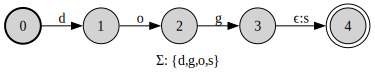

In [55]:
fst6 = pyfoma.FST.re("(dog):(dogs)")

print(list(fst6.generate("dog")))
print(list(fst6.generate("cat")))

fst6.view()

What if we wanted an FST that turns `dog` into `dogs` and `cat` into `cats`? We can do that as well.

['dogs']
['cats']


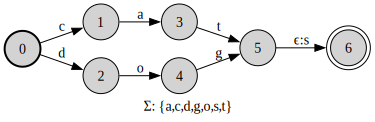

In [56]:
fst7 = pyfoma.FST.re("(dog):(dogs)|(cat):(cats)")

print(list(fst7.generate("dog")))
print(list(fst7.generate("cat")))

fst7.view()

## **English Pluralizer**
Let's write an FST that takes in *any* English noun and outputs the plural form. First, we could start with a simple approach that just adds `s` to the end of any word. We will use two new concepts:

- `.` accepts any character at all. `.*` accepts any character, any number of times (recall the [regex lesson](<./9. Regex.ipynb>)).
- `''` accepts the empty string. By doing `'':s`, we can *insert* an `s`.

['dogs']
['cats']
['babys']
['kisss']


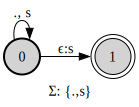

In [62]:
fst_naiveplural = pyfoma.FST.re("(.*)'':s")

print(list(fst_naiveplural.generate("dog")))
print(list(fst_naiveplural.generate("cat")))
print(list(fst_naiveplural.generate("baby")))
print(list(fst_naiveplural.generate("kiss")))

fst_naiveplural.view()

However, we can see that this isn't always right, since not all words are formed by just adding `s`. We need a more complicated approach.

### FSTs with rewrite rules
One approach to use different rules for pluralization is through *rewrite rules*, a formalism often used in phonology. Rewrite rules are defined as
```
$^rewrite(input:output / context)
```

where the context includes an underscore `_` for the position of the symbol.

For instance, the rule
```
$^rewrite( a:e / b _ )
```
Changes an `a` to an `e` when it occurs after a `b`. Let's see it in action.

In [65]:
fst_rewrite = pyfoma.FST.re("$^rewrite(a:e / b _)")

print(list(fst_rewrite.generate("bad bed bag bog baba")))

['bed bed beg bog bebe']


### Rewrite rules for pluralization
We can use rewrite rules to fix our pluralization approach. First, let's write a rule that fixes words like `babys` -> `babies`.

In [85]:
fst_ies_rule = pyfoma.FST.re("$^rewrite(y:(ie) / _ s #)")

print(list(fst_ies_rule.generate("babys")))
print(list(fst_ies_rule.generate("ladys")))
print(list(fst_ies_rule.generate("gravys")))

['babies']
['ladies']
['gravies']


Let's break down the rule.
```
$^rewrite(y:(ie) / _ s #)
```

- `y:(ie)` transforms `y` to `ie`
- `_` is the position of the `y`
- `_ s` indicates any `y`s occuring before `s`
- `#` is the end of the string

So this rule transforms `y` to `ie` any time the `y` is followed by an `s` and then the end of the string.

However, there's still an issue. What happens with a word like `boy`?

In [86]:
print(list(fst_ies_rule.generate("boys")))
print(list(fst_ies_rule.generate("rays")))
print(list(fst_ies_rule.generate("keys")))

['boies']
['raies']
['keies']


#### **Exercise 2**
Write a fixed FST that only applies the `y`->`ie` rewrite rule when the `y` is not preceded by a vowel. You can use the regex `[^abc]` to match any characters besides the characters specified (any character besides `a`, `b`, or `c`).

<details>
  <summary>Show answer</summary>
      <pre style="background-color: honeydew; padding: 10px; border-radius: 5px;"><code style="background: none;">fst_ies_rule_fixed = pyfoma.FST.re("$^rewrite(y:(ie) / [^aeiou] _ s (#|' '))") # TODO: Fix me!

print(list(fst_ies_rule_fixed.generate("babys ladys gravys")))
print(list(fst_ies_rule_fixed.generate("boys rays keys")))</code></pre></details>

In [96]:
fst_ies_rule_fixed = pyfoma.FST.re("$^rewrite(y:(ie) / _ s #)") # TODO: Fix me!

print(list(fst_ies_rule_fixed.generate("babys")))
print(list(fst_ies_rule_fixed.generate("ladys")))
print(list(fst_ies_rule_fixed.generate("gravys")))
print(list(fst_ies_rule_fixed.generate("boys")))
print(list(fst_ies_rule_fixed.generate("rays")))
print(list(fst_ies_rule_fixed.generate("keys")))

['babies']
['ladies']
['gravies']
['boies']
['raies']
['keies']


You may have noticed we stopped `view`ing the FSTs. This is because as they grow more complicated, the visual representation is less and less helpful. However, you're welcome to check it out!

### Combining FSTs
Now, we have an FST that adds `s` and one that applies the `y`->`ie` rule. We can combine those FSTs together using the `@` operator.

In [91]:
fsts = {
    "plural": fst_naiveplural,
    "y_rule": fst_ies_rule_fixed
}

combined_plural = pyfoma.FST.re("$plural @ $y_rule", fsts)
print(list(combined_plural.generate("dog")))
print(list(combined_plural.generate("cat")))
print(list(combined_plural.generate("baby")))
print(list(combined_plural.generate("kiss")))

['dogs']
['cats']
['babies']
['kisss']


Getting closer! Now we need to fix words like `kiss`. Specifically, for any word that ends in `s`, `z`, or `ch`, we should insert an `e` before the `s`.

#### **Exercise 3**
Finish the following FST for the `es` rule. 

<details>
  <summary>Show answer</summary>
      <pre style="background-color: honeydew; padding: 10px; border-radius: 5px;"><code style="background: none;">fst_es_rule = pyfoma.FST.re("$^rewrite(s:(es) / (s|z|ch) _ #)") # TODO: Fix me!
</code></pre></details>

In [93]:
fst_es_rule =  # TODO: Finish me!

print(list(fst_es_rule.generate("kisss")))
print(list(fst_es_rule.generate("catchs")))
print(list(fst_es_rule.generate("buzzs")))

['kisses']
['catches']
['buzzes']


Now, let's put our FSTs together into one big pluralizer.

In [94]:
fsts = {
    "plural": fst_naiveplural,
    "y_rule": fst_ies_rule_fixed,
    "es_rule": fst_es_rule
}

combined_plural = pyfoma.FST.re("$plural @ $y_rule @ $es_rule", fsts)
print(list(combined_plural.generate("dog")))
print(list(combined_plural.generate("cat")))
print(list(combined_plural.generate("baby")))
print(list(combined_plural.generate("kiss")))

['dogs']
['cats']
['babies']
['kisses']


Looks good!

## **Writing your own inflection FST**
Now, your challenge is to write another inflection FST, this time for [Spanish plurals](https://www.fluentu.com/blog/spanish/plural-in-spanish/). Specifically,
- If a word ends in a vowel, add `s` (*los niños*)
- If a word ends in a consonant, add `es` (*los colores*)
- If a word ends in `ión`, drop the accent and add `es` (*los aviones*)
- If a noun ends in `z`, change the ending to `ces` (*los lápices*)
- If a noun ends in `c` or `g`, change to `ques` or `gues` (*los fraques*)
- If a noun ends in `s` or `x` and the last syllable is unstressed, don't change the word (*lunes*)

There's a lot of rules here, so try your best to write as many as you can! Then, combine the rules into a single FST, as before.

In [ ]:
# TODO: Spanish pluralizer!